In [23]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import gym_gridworlds

In [24]:
env = gym.make("CartPole-v0")
env._max_episode_steps = 600

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [25]:
def softmax(x):
    exp_x = np.exp(x)
    return exp_x/np.sum(exp_x)

class Agent:
    def __init__(self, gamma: float, epsilon: float, alpha:float, n_actions: int):
        self.gamma=gamma
        self.epsilon=epsilon
        self.alpha=alpha
        self.n_actions=n_actions
        self.state_action_values={}
        self.state_values={}
    
    def get_next_action(self, state):
        raise NotImplementedError
        
    def update(self, state, action: int, reward, state_prime):
        raise NotImplementedError
        


        
class ExpectedSarsaAgent(Agent):
    def __init__(self, gamma=0.9, epsilon=0.1, alpha=0.01, n_actions=3):
        super().__init__(gamma=gamma, epsilon=epsilon, alpha=alpha, n_actions=n_actions)
        
    def get_next_action(self, state):
        self.initialize_action_values(state)
        action_values = self.state_action_values.get(state)
        if random.random() > self.epsilon: # Greedy
            return(max(action_values.items(), key=lambda x:x[1])[0])
        else: # Exploratory
            return(random.randint(0, self.n_actions-1))
    
    def update(self, state, action, reward, state_prime):
        self.initialize_action_values(state)
        self.initialize_action_values(state_prime)
        
        action_prime_values = self.state_action_values[state_prime]
        action_prime, values = zip(*action_prime_values.items())

        target = np.sum(np.array(values) * np.array(softmax(values)))
        td_error = reward + self.gamma*target - self.state_action_values[state][action]
        self.state_action_values[state][action] += self.alpha*(td_error)
                
    def initialize_action_values(self, state):
        action_values = self.state_action_values.get(state)
        if action_values is None:
            self.state_action_values[state] = {k:random.random() for k in range(self.n_actions)}
        
        
    

In [32]:
agent=ExpectedSarsaAgent(gamma=0.9, epsilon=0.1, alpha=0.1, n_actions=env.action_space.n)
cumulative_rewards=[]

In [33]:
state=env.reset()

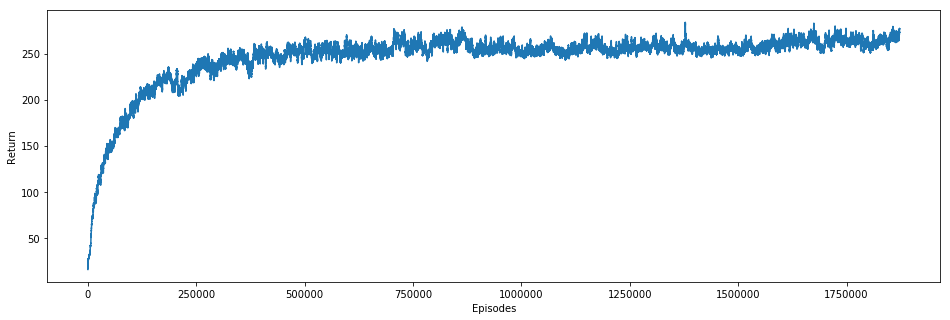

In [57]:
for episode in range(1e6):
    state = env.reset()
    state = tuple([round(s, 1) for s in state])
    done=False
    c=0
    cumulative_reward=0
    while not done:
        action = agent.get_next_action(state)
        state_prime, reward, done, _ = env.step(action)
        state_prime = tuple([round(s, 1) for s in state_prime])
        agent.update(state, action, reward, state_prime)
        state = state_prime
        cumulative_reward+=reward
        c+=1
    cumulative_rewards.append(cumulative_reward)
    if episode % 1000 == 0:
        clear_output(True)
        plt.figure(figsize=(16, 5))
        plt.xlabel("Episodes")
        plt.ylabel("Return")
        plt.plot(pd.Series(cumulative_rewards).ewm(span=1000).mean())
        plt.show()


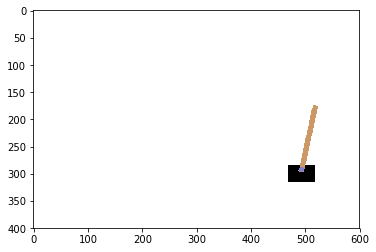

281 episodes completed until failure


In [59]:
state=env.reset()
done=False
c=0
while not done:
    state = tuple([round(s, 1) for s in state])
    action=agent.get_next_action(tuple(state))
    state, reward, done, _ = env.step(action)
    if c%5==0:
        clear_output(True)
        plt.imshow(env.render("rgb_array"))
        plt.show()
    c+=1
print("%s episodes completed until failure"%c)